# **Seq2Seq Model - Document Summarization**

### **1. Import data**

The dataset consists of NEWS SUMMARY dataset (by KONDALARAO VONTERU) and CNN-DailyMail News (by GOWRI SHANKAR P).

In [1]:
import pandas as pd

path = 'data/'

raw_text = pd.read_csv(path + "news_summary_more.csv", encoding='iso-8859-1')
summary = pd.read_csv(path + "news_summary.csv", encoding='iso-8859-1')

# cnn_text = pd.read_csv(path + "cnn_news.csv", encoding='iso-8859-1')

In [2]:
# cnn_text.head(2) # to see the columns name of different dataset

In [3]:
raw_prep = raw_text.iloc[:, 0:2].copy()
sum_prep = summary.iloc[:, 0:6].copy()

sum_prep['text'] = sum_prep['author'].str.cat(\
                   sum_prep['date'].str.cat(\
                   sum_prep['read_more'].str.cat(\
                   sum_prep['text'].str.cat(\
                   sum_prep['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

df = pd.DataFrame()
# df['text'] = pd.concat([raw_prep['text'], sum_prep['text'], cnn_text['article']], ignore_index=True)
# df['summary'] = pd.concat([raw_prep['headlines'], sum_prep['headlines'], cnn_text['highlights']], ignore_index=True)
df['text'] = pd.concat([raw_prep['text'], sum_prep['text']], ignore_index=True)
df['summary'] = pd.concat([raw_prep['headlines'], sum_prep['headlines']], ignore_index=True)

In [4]:
df.head(3)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...


### **2. Cleaning data**

Remove non-alphabetic characters from the dataset using regular expression library

In [5]:
import re

# Define function to clean data (ref: blog.paperspace)
def text_strip(col):
    for row in col:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

Clean the data by calling functions

In [6]:
cleaned_text = text_strip(df['text'])
cleaned_summary = text_strip(df['summary'])

Load data as batches (using **spacy**) and enclosed the summaries with starting and closing tokens

In [7]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

text = [str(raw) for raw in nlp.pipe(cleaned_text, batch_size = 80)]

summary = ['_START_' + str(raw) + '_END_' for raw in nlp.pipe(cleaned_summary, batch_size=80)]

The `_START_` and `_END_` tokens are used to determine the starting and ending points of the summaries, in which it could also be helpful to exclude the empty text.

In [18]:
print(f"Original text\n{raw_prep.text[0]}\n\nSample text\n{text[0]}\n\nSummary\n{summary[0]}")

Original text
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

Sample text
saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.

Summary
_START_upgrad learner switches to career in ml al with 90% salary hike_END_


### **3. Examine the data**

We will analyze the characteristics of the dataset, such as: maximum sequence lengths, most-frequent words, difference in length between raw texts and summaries.

In [19]:
df['cleaned_text'] = pd.Series(text)
df['cleaned_summary'] = pd.Series(summary)

After creating the list of texts and summaries, we will split each sequences to a list consisting multiple words by using `split' built-in function. From the lists we have created, a graph will be drawn to determine the range of length, from which we can derive the maximum number of words that frequently fall into.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

text_cnt = []
sum_cnt = []

for text_seq, sum_seq in zip(df['cleaned_text'], df['cleaned_summary']):
    text_cnt.append(len(text_seq.split()))
    sum_cnt.append(len(sum_seq.split()))

plot_df = pd.DataFrame()
plot_df['text'] = text_cnt
plot_df['summary'] = sum_cnt

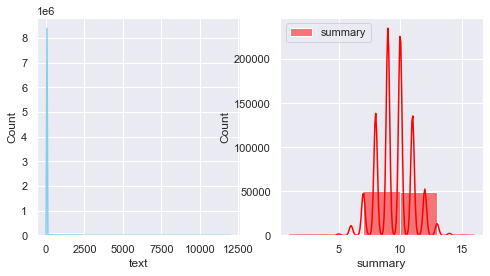

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(data=plot_df, x="text", color="skyblue", label="text", kde=True, bins=5, ax=ax[0])
sns.histplot(data=plot_df, x="summary", color="red", label="summary", kde=True, bins=5, ax=ax[1])

plt.legend() 
plt.show()

From the plot, we can confidently determine the maximum length of summaries would be 15 words. On the other hand, it seems like the range of texts is barely observerable. As said, we will use the violin plot to see the distribution density and determine the maximum length among them.

In [37]:
plot_df['text'].describe()

count    102915.000000
mean         71.555429
std         100.166101
min           1.000000
25%          56.000000
50%          58.000000
75%          59.000000
max       11999.000000
Name: text, dtype: float64

Since the data is heavily right skewed, we could remove some of the outliers by slicing (for visualization purpose only of course)

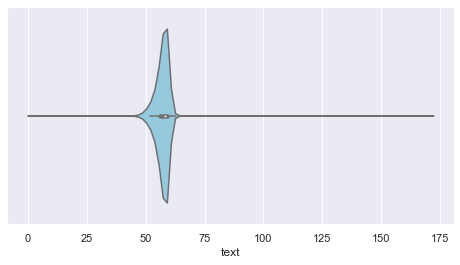

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(data=plot_df[plot_df.text < plot_df.text.mean() + plot_df.text.std()], x="text", color="skyblue", label="text", ax=ax)
plt.show()

The frequent lengths of texts fall into around 50 - 60 words. From here, we can assume the maximum length of texts to be 100 words, as almost sequences fall into the range below 100.

In [44]:
# Initialize the plausible length for texts and summaries
max_text_len = 100
max_sum_len = 15

### **4. Data Extraction**

In this section, we will select plausible texts and summaries for further training progress based on the length criteria proposed above.

In [49]:
import numpy as np

# We convert the dataframe to numpy for faster process
cleaned_text = np.array(df['cleaned_text'])
cleaned_summary = np.array(df['cleaned_summary'])

processed_text = []
processed_sum = []

for text, summary in zip(cleaned_text, cleaned_summary):
    if len(text.split()) <= max_text_len and len(summary.split()) <= max_sum_len:
        processed_text.append(text)
        processed_sum.append(summary)

post_processed_df = pd.DataFrame({'text': processed_text, 'summary': processed_sum})
post_processed_df.head(3)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_upgrad learner switches to career in ml...
1,kunal shah credit card bill payment platform c...,_START_delhi techie wins free food from swiggy...
2,new zealand defeated india by wickets in the f...,_START_new zealand end rohit sharma-led india ...


In [52]:
print(f"Pre-processed dataset\n{len(df)} sequences\nPost-processed dataset\n{len(post_processed_df)} sequences")

Pre-processed dataset
102915 sequences
Post-processed dataset
98572 sequences


Now, we add the indicator of starting point (`sok`: start of token) and ending point (`eos`: end of token) of sequence. This would help to determine the correct sequence during the tokenization phase.

Speaking of tokenization, it is a way of seperating a piece of text into smaller units called tokens (can be either characters, words or sub-words). For example, we want tokenize the sequence "Code is fun" by remove the space delimeter. So it would become 3 different words: 'Code', 'is' and 'fun', which is also results of words tokenization.

Another example would be tokenize the word "science" into s-c-i-e-n-c-e with characters tokenization, or into sc-ience with subwords tokenization (or n-gram).

Tokenization is performed on the corpus (documents/dataset/sequence) to obtain tokens, and these tokens will be feed to the formation of vocabulary which is a set of unique tokens in the corpus. Note that the `sok` and `eos` are different from `_START_` and `_END_` notations since the later tokens are used to remove empty sequences.

### **5. Tokenizing the dataset**

Forming the train and test dataset

In [77]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_processed_df["text"]),
    np.array(post_processed_df["summary"]),
    test_size=0.2,
    random_state=0,
    shuffle=True,
)

In [78]:
# Tokenize the text to get the vocabulary, using keras libraries
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [79]:
# Print out some tokens from the tokenizer
i = 5
for key, value in x_tokenizer.word_counts.items():
    if i == 0: break
    print(key, value)
    i-=1

samajwadi 270
party 3770
president 7272
akhilesh 186
yadav 1011


Excluding the very rare words

In [80]:
thresh = 5 # occurs less than 5 times

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  62.755014231813064


Since the rare words occupied the most in the vocabulary, we will tokenize the dataset again by using the total number of words minus the rare words. After that, by using the built-in function from keras, we will convert the text into number sequences, and padding the zeroes to ensure all sequences have the same length (which equal to the maximum length)

In [81]:
# Prepare a tokenizer but exclude the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print(f"Size of vocabulary in the text corpus {x_voc}")

Size of vocabulary in the text corpus 28134


Now let's prepare the tokenizer for summaries

In [82]:
# Prepare a tokenizer on training data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5 # occurs less than 5 times

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

# Prepare a tokenizer but exclude the rare words
y_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq,  maxlen=max_sum_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_sum_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print(f"Size of vocabulary in the summary corpus {y_voc}")

% of rare words in vocabulary:  63.294595988712565
Size of vocabulary in the summary corpus 12098


### **6. Remove empty sequences**

As we have disscued in preivous section, we will remove all empty summaries (which only have START and END tokens) and their associated texts from the data.

In [83]:
# Remove empty summaries, which only have 'START' and 'END' tokens
index = []
# Append the indices of empty sequences and remove with numpy
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        index.append(i)

y_tr = np.delete(y_tr, index, axis=0)
x_tr = np.delete(x_tr, index, axis=0)

Apply the same process for validation dataset

In [84]:
# Remove empty summaries, which only have 'START' and 'END' tokens
index = []
# Append the indices of empty sequences and remove with numpy
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        index.append(i)

y_val = np.delete(y_val, index, axis=0)
x_val = np.delete(x_val, index, axis=0)

### **7. Construct the model**

As the data is well-prepared until now, we will move on to create the model structure with the Tensorflow and Keras libraries

In [ ]:
# Import libraries for constructing models
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

The Seq2Seq consist of encoders and decoders in its network. In the next cells, we will define the encoder and decoder pipelines and then assemble them together in the future steps.

#### **7.1. Encoder**